In [2]:
from transformers import AutoTokenizer, AutoModel, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import get_scheduler


ckpt_path = 'snunlp/KR-SBERT-V40K-klueNLI-augSTS'
sbert_tokenizer = AutoTokenizer.from_pretrained(ckpt_path)
sbert_model = AutoModelForSequenceClassification.from_pretrained(ckpt_path, num_labels=9)

training_args = TrainingArguments("test-trainer")

torch.cuda.empty_cache()

/home/keonwoo/anaconda3/envs/bgmRS/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at snunlp/KR-SBERT-V40K-klueNLI-augSTS and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
class contentDataset(Dataset):
    def __init__(self, file, tok, max_len, pad_index=None):
        super().__init__()
        self.tok =tok
        self.max_len = max_len
        self.content = pd.read_csv(file)
        self.len = self.content.shape[0]
        self.pad_index = self.tok.pad_token
    
    def add_padding_data(self, inputs, max_len):
        if len(inputs) < max_len:
            # pad = np.array([self.pad_index] * (max_len - len(inputs)))
            pad = np.array([0] * (max_len - len(inputs)))
            inputs = np.concatenate([inputs, pad])
            return inputs
        else:
            inputs = inputs[:max_len]
            return inputs
    
    def __getitem__(self,idx):
        instance = self.content.iloc[idx]
        # text = "[CLS]" + instance['content'] + "[SEP]"
        text = instance['text']
        input_ids = self.tok.encode(text)
        
        input_ids = self.add_padding_data(input_ids, max_len=self.max_len)
        label_ids = instance['label']
        # encoder_attention_mask = input_ids.ne(0).float()
        return {"encoder_input_ids" : np.array(input_ids, dtype=np.int_),
                "label" : np.array(label_ids,dtype=np.int_)}
        
    def __len__(self):
        return self.len

In [39]:
dataset = pd.read_csv('/home/keonwoo/anaconda3/envs/bgmRS/data/labeled_data_0706.csv')
dataset.drop(['Unnamed: 0'],axis=1,inplace=True)

dataset['label'] = pd.factorize(dataset['label'])[0]
# dataset.columns = ['label','text']
dataset = dataset.sample(frac=1).reset_index(drop=True)


train_num = int(len(dataset)*0.9)
trainset = dataset.iloc[:train_num]
validset = dataset.iloc[train_num:]

trainset.to_csv('/home/keonwoo/anaconda3/envs/bgmRS/data/trainset.csv')
validset.to_csv('/home/keonwoo/anaconda3/envs/bgmRS/data/validset.csv')

train_setup = contentDataset(file = "/home/keonwoo/anaconda3/envs/bgmRS/data/trainset.csv",tok = sbert_tokenizer, max_len = 512)
valid_setup = contentDataset(file = "/home/keonwoo/anaconda3/envs/bgmRS/data/validset.csv",tok = sbert_tokenizer, max_len = 512)


tarin_dataloader = DataLoader(train_setup, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_setup, batch_size=32, shuffle=False)

optimizer = AdamW(sbert_model.parameters(), lr=5e-5)


num_epochs = 5
num_training_steps = num_epochs * len(tarin_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [40]:
from torch.nn.parallel import DistributedDataParallel

n_gpus = torch.cuda.device_count()


device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
sbert_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(40000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [41]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
loss_list = []

sbert_model.train()
for epoch in range(num_epochs):
    for batch in tarin_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        encoder_attention_mask = batch["encoder_input_ids"].ne(0).float().to(device)
        outputs = sbert_model(batch['encoder_input_ids'], attention_mask=encoder_attention_mask, labels=batch['label'])
        loss = outputs.loss
        loss_list.append(loss.item())
        
        loss.backward()
        
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

100%|██████████| 940/940 [3:10:42<00:00, 12.17s/it]


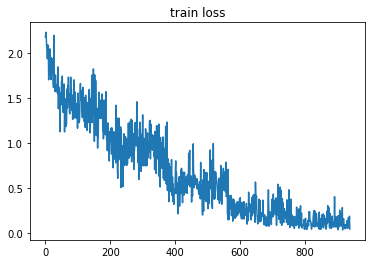

In [50]:
from matplotlib import pyplot as plt

plt.plot(loss_list)
plt.title('train loss')
plt.show()

In [51]:
import os
# os.makedirs("/home/keonwoo/anaconda3/envs/bgmRS/ckpt/sbert_snu")

sbert_model.save_pretrained("/home/keonwoo/anaconda3/envs/bgmRS/ckpt/sbert_snu_added_0706")

In [44]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

model = AutoModelForSequenceClassification.from_pretrained("/home/keonwoo/anaconda3/envs/bgmRS/ckpt/sbert_snu_added_0706", num_labels=9)
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(40000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [45]:
from tqdm.auto import tqdm
from datasets import load_metric

pred = []
ref = []

model.eval()
for batch in valid_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    encoder_attention_mask = batch["encoder_input_ids"].ne(0).float().to(device)
    with torch.no_grad():
        outputs = model(batch['encoder_input_ids'], attention_mask=encoder_attention_mask, labels=batch['label'])
        
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    pred.append(predictions)
    ref.append(batch['label'])

pred = torch.cat(pred, 0)
ref = torch.cat(ref, 0)

In [46]:
acc = load_metric("accuracy")
recall = load_metric("recall")
f1 = load_metric("f1")
prec = load_metric("precision")


acc.compute(predictions=pred, references=ref)

{'accuracy': 0.5853293413173652}

In [47]:
prec.compute(predictions=pred, references=ref, average="weighted")

{'precision': 0.5873393452691532}

In [48]:
recall.compute(predictions=pred, references=ref, average="weighted")

{'recall': 0.5853293413173652}

In [49]:
f1.compute(predictions=pred, references=ref, average="weighted")

{'f1': 0.5846380774496138}

#### added

In [27]:
acc = load_metric("accuracy")
recall = load_metric("recall")
f1 = load_metric("f1")
prec = load_metric("precision")


acc.compute(predictions=pred, references=ref)

{'accuracy': 0.5523590333716916}

In [28]:
prec.compute(predictions=pred, references=ref, average="weighted")

{'precision': 0.5570793837339553}

In [29]:
recall.compute(predictions=pred, references=ref, average="weighted")

{'recall': 0.5523590333716916}

In [30]:
f1.compute(predictions=pred, references=ref, average="weighted")

{'f1': 0.5532513359552833}

### To result

In [52]:
validset['pred'] = pred.detach().cpu().numpy()

/tmp/ipykernel_57634/2334514741.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validset['pred'] = pred.detach().cpu().numpy()


In [53]:
label_dict = {
    '희망적인' : 0,  # 소분류
    '감동적인' : 1, # 소분류
    '무서운' : 2,  # 불안 -> 소분류
    '로맨틱한' : 3, # 소분류
    '평화로운' : 4, # 소분류
    '멋진' : 5, # 소분류
    '우스운' : 6, # 소분류
    '신나는' : 7, # 소분류
    '쿨한' : 8 # 소분류
}

reversed_dict = dict(map(reversed, label_dict.items()))

def change_label(x):
    return reversed_dict[x]

validset['Actual Label'] = validset['label'].apply(lambda x: change_label(x))
validset['Pred Label'] = validset['pred'].apply(lambda x: change_label(x))
validset.drop(['label','pred'],axis=1,inplace=True)

validset.to_csv('tmp_snu_added_0706.csv')

/tmp/ipykernel_57634/402622896.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validset['Actual Label'] = validset['label'].apply(lambda x: change_label(x))
/tmp/ipykernel_57634/402622896.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validset['Pred Label'] = validset['pred'].apply(lambda x: change_label(x))
/tmp/ipykernel_57634/402622896.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

In [54]:
import pandas as pd

data = pd.read_csv('tmp_snu_added_0706.csv')
data.drop(['Unnamed: 0'],axis=1,inplace=True)
data.head()

,text,Actual Label,Pred Label
0,온돌 침대를 준 자식들에게 너무 고마워서 고마움의 표시를 하고 싶네.,감동적인,멋진
1,어머니에게 도움이 되는 가장 좋은 방법이 어떤 방법일까요?,멋진,멋진
2,우리 부장님께서는 어려운 업무도 알기 쉽게 설명해 주셔서 너무 감사해.,감동적인,멋진
3,내 느낌에 이번 모의고사 평균 이 등급 받을 수 있을 거 같아!,신나는,신나는
4,우리 둘 다 등산을 좋아해서 주말마다 아내랑 산에 다니는 것이 너무 만족스러워.,평화로운,평화로운


In [55]:
not_correct = []
for i in range(len(data)):
    if data.iloc[i]['Actual Label'] != data.iloc[i]['Pred Label']:
        not_correct.append(i)

In [56]:
data.iloc[not_correct].tail(30)

,text,Actual Label,Pred Label
588,앞으로도 건강하셨으면 좋겠어요.,로맨틱한,신나는
593,당신이 원하는 것을 다 할 수 있길 바라요.,로맨틱한,신나는
595,내가 생각하던 나보다 실제의 나는 좀 더 별로인가 봐.,무서운,우스운
596,응. 엄하기로 유명한 교수님인데 칭찬을 해주셨거든.,희망적인,멋진
600,친구와 함께 찍었던 사진이 위로가 되었으면 좋겠네요.,무서운,감동적인
601,무리하지 않는 선에서 일주일에 두세 번은 야외에서 운동을 해야겠어.,평화로운,로맨틱한
602,언니와 더욱 친해지면 좋겠네요.,멋진,평화로운
605,상황을 극복하기 위해 어떤 행동을 하면 좋을까요?,감동적인,희망적인
606,기분이 좋으시군요.,쿨한,로맨틱한
608,무슨 좋은 일이 생겼어요?,쿨한,평화로운
